
# Project: Investigate a Dataset
<h1><center>Messi vs Ronaldo</center></h1>
![Image](http://e00-marca.uecdn.es/assets/multimedia/imagenes/2017/05/22/14954605739799.jpg)


### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul> 

<a id='intro'></a>
## Introduction

Probably one of the most discussed rivaliries of the decade and the one most disagreed upon. In this analysis, we will put aside the subjective comments, sympathy, media bias and let <a href="https://www.kaggle.com/hugomathien/soccer">data</a> decide! (hopefully)

Below, I will investigate 2 of the best ***active*** footballers (cos' we know Pele is good, Maradona is better and <a href="https://en.wikipedia.org/wiki/George_Best">George Best</a> right? ) of the world from the following perspectives:

  1. Change of average nr of goals scored by their team when they play
  
  2. Change of thier team's possession when they play
  
  3. Shot distance distributions from the target
  
  4. Preferred shot locations on the pitch 
   

In [16]:
# Standard libraries required for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m

# Additional libraries for more fancy stuff :) 
import sqlite3
import xml.etree.ElementTree as ET

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

We will work with the European Football Database from <a href="https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True">suggested sources</a>. Although, in daily work I prefer to do most of the job with SQL on the database side; to be able to practice more pandas and numpy, I keep SQL queries as simple as possible.


### Data Cleaning and Formatting Functions

Below are two simple functions to fetch required data directly from the sqlite database, which was dully, but nevertheless cleverly named "database.sqlite"



In [17]:
def player_id(name):  
    """ 
    fetches the first player_api_id for a footballer part of whose name is like "name" 
    from "Player" table. 
    
    Note that instead of requiring exact name, we prefer "like" and if there is more than one 
    player we take the first one. Because, finding 2 Messi's is less painful than trying to write 
    Pierre Emerick Aubemeyang correct all the time!
    
    Args: 
        name(str): name or some part of name
    
    Returns: 
        player_api_id 
    """
    
    conn = sqlite3.connect("database.sqlite")
    df = pd.read_sql_query("select Player.player_api_id from Player where player.player_name like :name", 
                             conn, params = {"name": '%'+name+'%'})
    
    return int(df.player_api_id[0])

In [18]:
def match_data(date, team_name, player_name):
    """
    This function gets all the columns from the "Match" table in the database according to the input filters below 
    and adds some additional columns that will become handy.

    Args:
        date (str): YYYY-MM-DD format string
        team_name (str): Name or part of the name of the team of interest
        player_name (str): Name or part of name of player of interest

    Returns:
        pandas.DataFrame 
    """
    conn = sqlite3.connect("database.sqlite")
    
    # get the match details of a team starting from a given date
    df = pd.read_sql_query('''select *  from match, Team 
            where (match.home_team_api_id == Team.team_api_id or match.away_team_api_id == Team.team_api_id) 
            and date(date) > date(:date)
            and Team.team_long_name like :team_name'''
            ,conn, params = {"date":date, "team_name": '%'+ team_name + '%'})
    
    # column to decide whether this row is an away or home game for the "team_name"
    df["ha"] = np.where(df.home_team_api_id == df.team_api_id, 'h', 'a')
    
    # decide if "team_name" team draw(d), won(w) or lost(l) the match
    df["result"] = 'd'
    df["result"] = np.where((df["ha"] == 'h') & (df.home_team_goal > df.away_team_goal), 'w', df["result"])
    df["result"] = np.where((df["ha"] == 'h') & (df.home_team_goal < df.away_team_goal), 'l', df["result"])
    df["result"] = np.where((df["ha"] == 'a') & (df.home_team_goal > df.away_team_goal), 'l', df["result"])
    df["result"] = np.where((df["ha"] == 'a') & (df.home_team_goal < df.away_team_goal), 'w', df["result"])
    
    # to determine the goals of the team of interest
    df["goals"] = np.where((df["ha"] == 'h'), df.home_team_goal, df.away_team_goal)
    
    # check the player in the squads 
    squad = df.loc[:, 'home_player_1':'away_player_11']
    a=squad[squad == player_id(player_name)].sum(axis = 1)
    df["played"] = np.where((a > 0), True, False)   
     
    return df

Functions above were using directly the values of columns of dataframes to create new columns. If we look closely, we see that some of the columns are in fact in "xml" format. It is more ticky to extract information from those columns. So let's accept the challenge! :) 

Below we define functions to parse these xml data. We will later use these functions to apply row by row transformations via lambda functions property of Python on pandas.DataFrame class. 

In [19]:
def possession(possession_xml, home_away):  
    '''
    Extracts the final possession ratio of the team of interest from the xml format below:
    
    <value>
       <comment>50</comment>
       <event_incident_typefk>352</event_incident_typefk>
       <elapsed>45</elapsed>
       <subtype>possession</subtype>
       <sortorder>1</sortorder>
       <awaypos>50</awaypos>
       <homepos>50</homepos>
       <n>97</n>
       <type>special</type>
       <id>520180</id>
    </value>

    Args: 
        possession_xml(str): xml part for posession report of that game
        home_away (str): whether the game is home('h') or away ('a') game
    
    Returns
        possession (int): Final possession ratios at the end of the game 
    '''
       
    # if the possession xml is empty this will never be updated 
    # and we simply return None so that it won't mess up calculations
    possession = None
    
    possession_tag = ET.fromstring(possession_xml)
    
    # we do not know how many possession reports will be per game (usually 4 times at different minutes)
    # we loop and keep overwriting until the end so that we get the last possession ratio
    # not as efficient as counting <value> tags and taking the last, but does the job for now :) 
    for value_tag in possession_tag:        
        for tag in value_tag:                                             
            if tag.tag == "homepos" and home_away == 'h':              
                possession = int(tag.text)               
            elif tag.tag == "awaypos" and home_away == 'a':               
                possession = int(tag.text)          
                
    return possession

The next function works similar and collects the "coordinates" from shoton or shotoff columns in xml format. For this analysis I preferred to combine shoton and shotoff columns to analyse the shot preference of a particular player, whether it be on target or not.

Here a careful examination of the "coordinates" data reveals that 
***pitch is divided in 44 grids on X axis and 69 grids in Y axis. *** and <a href="https://en.wikipedia.org/wiki/Football_pitch">here</a> it says "the preferred size for many professional teams' stadiums is ***105 by 68 meters***" which means if we ***scale actual grid coordinate wtih 1.5***  we can get a pretty good approximation in meters. This scaling factor will be crucial while looking at shot distance distributions.

Also after examining the shot data in detail, I observed that direction of attack changes at home and away games. 

   * Home team attacks at the goal at grid coordinates (22,0) 
   * while away team attacks at the goal at grid coordinates (22,69)
   
   ![Image](grids.jpg)

In [20]:
def shot_coordinates( shoton_xml, shotoff_xml, player_id, ha):
    '''
    Parses the shot coordinate information of a player according to the xml format below 
    
    <value>
        <stats>
           <blocked>1</blocked>
        </stats>
        <event_incident_typefk>61</event_incident_typefk>
        <coordinates>
           <value>24</value>
           <value>14</value>
        </coordinates>
        <elapsed>9</elapsed>
        <subtype>blocked_shot</subtype>
        <player1>75489</player1>
        <sortorder>0</sortorder>
        <team>9825</team>
        <n>199</n>
        <type>shoton</type>
        <id>3647350</id>
     </value>
     
    Args: 
         shoton_xml (str): shoton infotmation in xml format
         shotoff_xml (str): shotoff infotmation in xml format
         player_id = id of player to filter shots during a game
             
    Returns:
        Nx2 numpy array 
    '''
    
    # this will be filled with N 2x1 arrays 
    # where N is the number of shots taken by that player 
    a=[]
    
    # target goal changes for home/away team
    goal_x = { 'h': 22, 'a': 22 }
    goal_y = { 'h': 0 , 'a': 69 }
          
    shot_tag = ET.fromstring(shoton_xml)
       
    for value_tag in shot_tag:           
        if value_tag[2].tag == "coordinates":      
            if int(value_tag[5].text) == player_id:   
                 
                a.append({ 'x' :int(value_tag[2][0].text)
                          ,'y': int(value_tag[2][1].text)
                          ,'d': m.hypot( 1.5*(goal_x[ha]-int(value_tag[2][0].text))
                                        ,1.5*(goal_y[ha]-int(value_tag[2][1].text)))})       
                
    shot_tag = ET.fromstring(shotoff_xml)
       
    for value_tag in shot_tag:           
        if value_tag[2].tag == "coordinates":      
            if int(value_tag[5].text) == player_id: 
                
                a.append({ 'x' :int(value_tag[2][0].text)
                           ,'y': int(value_tag[2][1].text)
                          ,'d': m.hypot( 1.5*(goal_x[ha] - int(value_tag[2][0].text))
                                         ,1.5*(goal_y[ha]-int(value_tag[2][1].text)))})       
          
    return a


Note that we are going to compare two players. Although there is no technical limit for a player who played for more than one team to be compared to other, it is more intiutive and statistically meaningful to keep their playing period and number of games they played as close as possible. 

For the case of Christiano Ronaldo and Lionel Messi, we choose Ronaldo's <a href="https://www.transfermarkt.com/cristiano-ronaldo/transfers/spieler/8198/transfer_id/308498">transfer time</a> (1 July 2009) to Real Madrid as the start of date filtering. Since then none of the players had serious injury and for the Martians, Leo Messi is a product of Barcelona youth academy and has been playing in Barcelona since he was a small (literally small) kid.

Let's create 2 pandas.DataFrames for Barcelona and Real Madrid, and for Messi and Ronaldo respectiveliy...

Following dataFrames will be our main source of data throughout the analysis, hence I preferred to choose short names. It will be easier to follow if we keep in mind that

   ***df_r*** is the match data of Real Madrid 
   
   ***df_b*** is the match data of FC Barcelona
  


In [21]:
df_r = match_data( "2009-07-01", "Real Madrid", "Cristiano Ronaldo" )
df_r.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,BSA,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,ha,result,goals,played
0,21898,21518,21518,2009/2010,1,2009-08-29 00:00:00,684585,8633,9783,3,...,11.00,43040,8633,243,Real Madrid CF,REA,h,w,3,True
1,21913,21518,21518,2009/2010,10,2009-11-07 00:00:00,684734,9906,8633,2,...,1.91,43040,8633,243,Real Madrid CF,REA,a,w,3,False
2,21923,21518,21518,2009/2010,11,2009-11-21 00:00:00,684755,8633,8696,1,...,12.00,43040,8633,243,Real Madrid CF,REA,h,w,1,False
3,21934,21518,21518,2009/2010,12,2009-11-29 00:00:00,684766,8634,8633,1,...,4.20,43040,8633,243,Real Madrid CF,REA,a,l,0,True
4,21944,21518,21518,2009/2010,13,2009-12-05 00:00:00,684776,8633,9865,4,...,15.00,43040,8633,243,Real Madrid CF,REA,h,w,4,True


In [22]:
df_b = match_data( "2009-07-01", "Barcelona", "Messi" )
df_b.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,BSA,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,ha,result,goals,played
0,21905,21518,21518,2009/2010,1,2009-08-31 00:00:00,684592,8634,9869,3,...,15.00,43042,8634,241,FC Barcelona,BAR,h,w,3,False
1,21915,21518,21518,2009/2010,10,2009-11-07 00:00:00,684736,8634,8661,4,...,15.00,43042,8634,241,FC Barcelona,BAR,h,w,4,False
2,21924,21518,21518,2009/2010,11,2009-11-21 00:00:00,684756,8315,8634,1,...,1.50,43042,8634,241,FC Barcelona,BAR,a,d,1,True
3,21934,21518,21518,2009/2010,12,2009-11-29 00:00:00,684766,8634,8633,1,...,4.20,43042,8634,241,FC Barcelona,BAR,h,w,1,True
4,21943,21518,21518,2009/2010,13,2009-12-05 00:00:00,684775,9783,8634,1,...,1.67,43042,8634,241,FC Barcelona,BAR,a,w,3,True


### Research Question 1 (Change of average nr of goals scored when they play)

We group the total goals scored by the players' presence in the game and calculate the averages. 

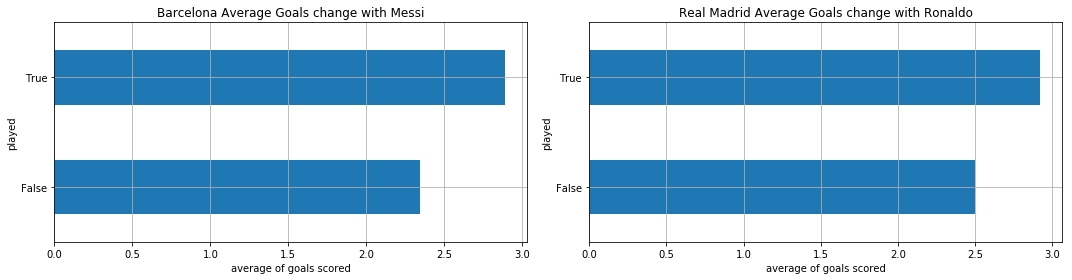

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_figwidth(15)

axes[0].set_title("Barcelona Average Goals change with Messi")
axes[1].set_title("Real Madrid Average Goals change with Ronaldo")

axes[0].set_xlabel("average of goals scored")
axes[1].set_xlabel("average of goals scored")

df_b.groupby(["played"])["goals"].mean().plot(ax=axes[0], kind ="barh", grid = True)             
df_r.groupby(["played"])["goals"].mean().plot(ax=axes[1], kind ="barh", grid = True)               

plt.tight_layout()

From the results above, we see that number of goals scored by their respective teams increase if Messi/Ronaldo is on starting 11. 

However, we cannot conclude that FC Barcelona/Real Madrid will score ~0.5 goals more when Messi/Ronaldo plays. There are several factors that decide if these star players will be on squad or not and even more factors that affect the number of goals thier team scores in a match. Nevertheless, for a decent football fan, thier contribution is understandable and not these resultsare expected.


### Research Question 2 (Change of team possession when they play)

For each dataframe we apply possession function to fetch the possession of their teams at the end of the game. Then we group the possession values by the players presence in the game and calculate the averages. 

In [24]:
df_b['match_possession'] = df_b.apply(lambda x: possession(x["possession"],x["ha"]), axis=1)
df_r['match_possession'] = df_r.apply(lambda x: possession(x["possession"],x["ha"]), axis=1)

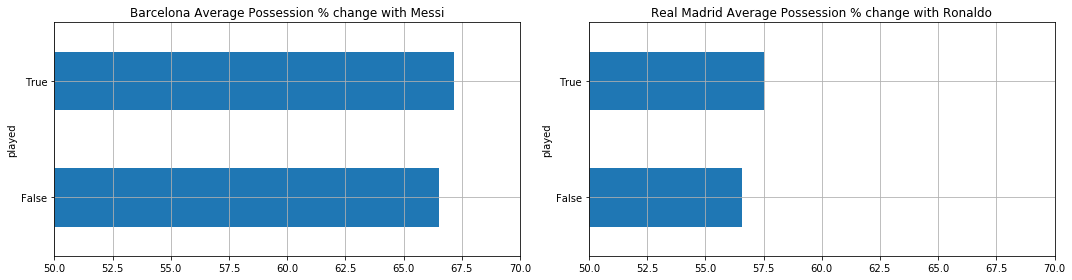

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].set_title("Barcelona Average Possession % change with Messi")
axes[0].set_xlim([50,70])
axes[1].set_title("Real Madrid Average Possession % change with Ronaldo")
axes[1].set_xlim([50,70])

fig.set_figwidth(15)

df_b.groupby(["played"])["match_possession"].mean().plot(ax=axes[0], kind ="barh", grid = True)  
df_r.groupby(["played"])["match_possession"].mean().plot(ax=axes[1], kind ="barh", grid = True)  


plt.tight_layout()

Similar to the average nr of goals scored when they play, their respective team's possesission is higher when Messi/Ronaldo is on starting 11. 

Again possession is dependent on several factors and whether Messi/Ronalso plays is one of the factors. 

Another observation we can make is the fact that Barcelona plays with higher possession comppared to Real Madrid, which is again an expected result.


### Research Question 3 (Shot distance distributions)

For each dataframe we apply shot_coordinates function to prepare shot locations and distance to the goal. Then we unwrap the distance values and plot the density of shot distances for the two players.

In [26]:
df_b["shots"] = df_b.apply(lambda x: shot_coordinates(x["shoton"], x["shotoff"], player_id("Messi"), 
                                                      x["ha"]), axis=1)
df_r["shots"] = df_r.apply(lambda x: shot_coordinates(x["shoton"], x["shotoff"], player_id("Cristiano Ronaldo"), 
                                                      x["ha"]), axis=1)


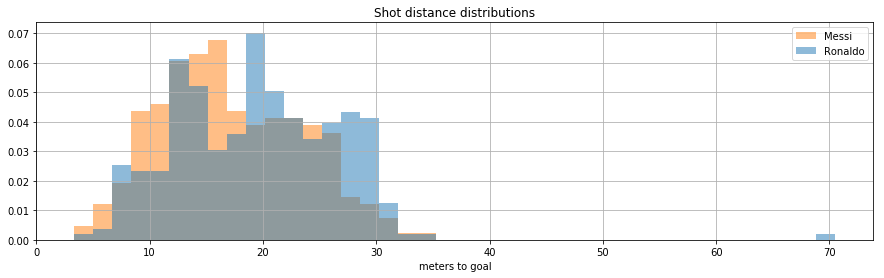

In [27]:
ronaldo = list()
messi = list()

# unwrap each and every distance in the shots column 
# into a list so that it can be plotted properly
for shots in df_r["shots"]:
    for shot in shots:
        ronaldo.append(shot['d'])
               
for shots in df_b["shots"]:
    for shot in shots:
        messi.append(shot['d'])

#  plotting and formatting
plt.figure(figsize=(15,4))
plt.title("Shot distance distributions")
plt.xlabel("meters to goal")
plt.grid()
plt.hist([ronaldo, messi] , histtype = 'stepfilled', alpha = 0.5, bins=40, density = True, 
         label = ["Ronaldo" , "Messi"])
plt.legend()
        

Distributions above show a fundamental difference between two players clearly. 

As a quick dribbler and excellent finisher of a team with high possession ratio, Messi prefers to get closer to the goal before he takes a shot. Ronaldo on the other hand can shoot from distance and more interestingly has 3 peaks around 15, 20 and 27 meters approximately.

These peaks can be further analysed, because football pitch is 2 dimensional. We will do this analysis on Research question nr 4.

### Research Question 4 (Preffered shot locations on the pitch)

We will use a similar unwrapping to research question 3, this time for coordiantes X and Y from the "shots" column that we created before. 

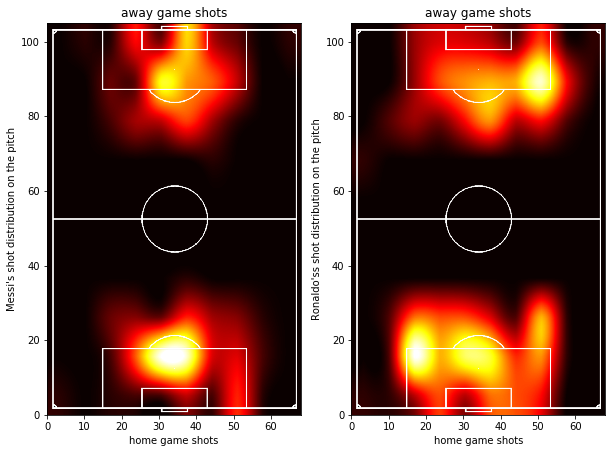

In [28]:
# initial values are to make sure that heatmap preserves
# the shot locations wrt the pitch(grid) dimensions
# this slightly afects the data as these samples do not
# exist in reality, but it is negligible for practical 
# purposes. Any suggestions are welcome here :) 

messi_x = list([0,44])
messi_y = list([0,69])
ronaldo_x = list([0,44])
ronaldo_y = list([0,69])

# unwrap every location an append it to a list
for shots in df_b["shots"]:
    for shot in shots:
        messi_x.append(shot["x"])
        messi_y.append(shot["y"])
        
for shots in df_r["shots"]:
    for shot in shots:
        ronaldo_x.append(shot["x"])
        ronaldo_y.append(shot["y"])

# calculate heatmaps      
heatmap_messi, m_xedges, m_yedges = np.histogram2d(messi_x, messi_y)
heatmap_ronaldo, r_xedges, r_yedges = np.histogram2d(ronaldo_x, ronaldo_y)

# actual pitch size ratio in meters
extent = [0, 68, 0, 105]

# plot
fig1 = plt.figure(figsize = (10,10)) 
ax1 = fig1.add_subplot(1,2,1) 
ax2 = fig1.add_subplot(1,2,2) 

ax1.set_title("away game shots")
ax1.set_xlabel("home game shots")
ax1.set_ylabel("Messi's shot distribution on the pitch")
ax1.imshow(heatmap_messi.T, extent = extent, origin='lower', interpolation = "spline16", cmap ='hot')
img = plt.imread("field.png")
ax1.imshow(img, extent=extent)

ax2.set_title("away game shots")
ax2.set_xlabel("home game shots")
ax2.set_ylabel("Ronaldo'ss shot distribution on the pitch")
ax2.imshow(heatmap_ronaldo.T, extent = extent, origin='lower', interpolation = "spline16", cmap ='hot')
img = plt.imread("field.png")
ax2.imshow(img, extent=extent)
                

Heatmaps above tell a lot of information about these players!

Note how Messi takes his shots as he gets into the box usually from center. He is a free moving <a href="http://www.thefalse9.com/2013/09/football-tactics-for-beginnersthe-false.html">false 9</a> and this is what he does best.

On the other hand Ronaldo has 2 characters. He is generally a free wandering wing attacker and as soon as he reaches at the right edge of the box he takes his shot with a stronger right food. This is the 3rd peak around 27 meters on density function of research question 3. He also shoots from the center as he is free moving attacker. Note also how he goes more central positions at home games while on away games he stays on the right as takes shot. This is because, away attacks are usually counter attacks where he runs to the opponent goal from right, and he as less time to wander freely into the center.


<a id='conclusions'></a>
## Conclusions

In this analysis we tried to go deep into the performances of 2 of the best active footballers in the world. 

We observed that, at their presence both their teams has higher average goals and possession. Although their presence is not the only factor that affect these variables we found out expected results. We also confirmed the high possession tactic of FC Barcelona. 

Then we focused on shot location variable, which is only affected form the players choice. We observed that Messi takes most of his shots around 16 meters to the goal, while Ronaldo has 3 major characters of shot selection. 

Since distance only is a 1d variable, while football pitch is a 2d plane, we dig deeper into this shot selection characteristics and found out interesting details. Well, at least it was for me! :)

### Limitations
 
For research questions 1 and 2, most important limitation of the analysis comes from the fact that number of games these players played is much less than the number of games they did not play. Also as stated above the fact that they played or not is likely to be closely related to the difficulty of the game which can strongly affect number of goals scored and possession, which are the metrics we analysed.


For research questions 3 and 4, the most important limitation is the fact that coordinate data of shots is started to be recorded from 2014/2015 season and the last data is from 2015/16 season. This means that, the data shows the behaviour of these players only for the years 2014 to 16. It must also be noted that we assume the reported coordinates are all correct.


### Potential areas to explore
 
There are a lot of additional questions that can be answered form this data. One very interesting point would be to analyse teams behaviour on the pitch instead of players. This would increase the available data and may lead to more certain observations. 

Data also includes the starting positions of players on 10x10 grid. This information can be used to analyse most preferred tactical formations by teams. 

Thanks for this enjoyable project!..

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'investigate-a-dataset_submit.ipynb'])

255